# YOLO Pretraining with IMAGENET-VID

## Imports

In [ ]:
%pip install huggingface_hub transformers accelerate timm ultralytics xmltodict

In [1]:
import os
import shutil
from os import path

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from ultralytics import YOLO

import numpy as np
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt

### Check GPU Availability

In [2]:
!nvidia-smi

Sun Mar 23 23:12:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0 Off |                  N/A |
|  0%   40C    P8             12W /  285W |      10MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Set CUDA Device Number 0~7
DEVICE_NUM = 0
ADDITIONAL_GPU = 0

if torch.cuda.is_available():
    if ADDITIONAL_GPU:
        torch.cuda.set_device(DEVICE_NUM)
        device = torch.device("cuda")
    else:
        device = torch.device(f"cuda:{DEVICE_NUM}")
else:
    device = torch.device("cpu")
    DEVICE_NUM = -1

print(f"INFO: Using device - {device}" + (f":{DEVICE_NUM}" if ADDITIONAL_GPU else ""))

INFO: Using device - cuda:0


## Define Dataset
ImageNet-VID

In [4]:
from typing import Callable, Optional
from pathlib import Path
import huggingface_hub
import xmltodict
import sys


class ImageNetVIDDataset(datasets.ImageFolder):
    """
    ImageNet-VID dataset for Object Detection and Tracking.
    Only works in Linux.

    :ref: https://huggingface.co/datasets/guanxiongsun/imagenetvid
    """

    download_method = huggingface_hub.snapshot_download
    dataset_name = "ILSVRC2015_VID"
    dataset_id = "guanxiongsun/imagenetvid"
    obj_classes = [
        "n02691156", "n02419796", "n02131653", "n02834778", "n01503061",
        "n02924116", "n02958343", "n02402425", "n02084071", "n02121808",
        "n02503517", "n02118333", "n02510455", "n02342885", "n02374451",
        "n02129165", "n01674464", "n02484322", "n03790512", "n02324045",
        "n02509815", "n02411705", "n01726692", "n02355227", "n02129604",
        "n04468005", "n01662784", "n04530566", "n02062744", "n02391049"
    ]
    obj_class_namees = [
        "airplane", "antelope", "bear", "bicycle", "bird", "bus", "car", "cattle",
        "dog", "domestic cat", "elephant", "fox", "giant panda", "hamster", "horse",
        "lion", "lizard", "monkey", "motorcycle", "rabbit", "red panda",
        "sheep", "snake", "squirrel", "tiger", "train", "turtle",
        "watercraft", "whale", "zebra"
    ]

    def __init__(
        self,
        root: str,
        force_download: bool = True,
        train: bool = True,
        valid: bool = False,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None
        ):
        self.root = path.join(root, self.dataset_name)
        self.download(self.root, force=force_download)
        self.default_target_transform = transforms.Lambda(lambda x: self.query_annotation(x))
        target_transform = transforms.Compose([
            self.default_target_transform, target_transform
        ]) if target_transform is not None else self.default_target_transform

        if train:
            self.root = path.join(self.root, "val") if valid else path.join(self.root, "train")
        else:
            self.root = path.join(self.root, "test")

        super().__init__(root=self.root, transform=transform, target_transform=target_transform)
        self.cached_annotations = [None] * len(self.samples)
        self.samples = [(data[0], (data[1], idx)) for idx, data in enumerate(self.samples)]

    def query_annotation(self, img_info: int):
        img_index = img_info[1]
        cache = self.cached_annotations[img_index]
        if cache is None:
            file_path = self.samples[img_index][0].replace(".jpeg", ".xml").replace(".JPEG", ".xml")

            with open(file_path, 'r', encoding='utf-8') as f:
                xml_content = f.read()
                cache = self.cached_annotations[img_index] = xmltodict.parse(xml_content)['annotation']

            try:
                objects = cache['object'] if isinstance(cache['object'], list) else [cache['object']]  # Make sure it is a list
                del cache['object']
                cache['labels'] = [self.obj_classes.index(obj['name']) for obj in objects]
                cache['boxes'] = [
                    [float(obj['bndbox'][key]) for key in ['xmin', 'ymin', 'xmax', 'ymax']] for obj in objects
                ]
            except KeyError:
                cache['labels'], cache['boxes'] = [], []
        return cache

    @staticmethod
    def label_transform(img_info: dict, normalize: bool = False):
        bboxes_info, labels_info = img_info['boxes'], img_info['labels']
        if normalize:
            height, width = float(img_info['size']['height']), float(img_info['size']['width'])
            bboxes_info = [[
                bbox_info[0] / width, bbox_info[1] / height,  # xmin, ymin
                bbox_info[2] / width, bbox_info[3] / height  # xmax, ymax
            ] if bbox_info else bbox_info for bbox_info in bboxes_info]
        return dict(boxes=torch.tensor(bboxes_info), labels=torch.tensor(labels_info))

    @classmethod
    def download(cls, root: str, force: bool = False):
        root = Path(root)

        # Clean up the existing dataset if force is flagged
        if force:
            print(f"INFO: Cleaning up the existing dataset at {root} (Force-download is flagged)")
            for item in os.listdir(root):
                item_path = root / item
                if path.isfile(item_path):
                    os.remove(item_path)
                else:
                    shutil.rmtree(item_path)
            print("INFO: Dataset cleaned successfully.")

        # Do download if the dataset does not exist
        print(f"INFO: Downloading '{cls.dataset_id} from huggingface to {root}...")
        dnlod = lambda: cls.download_method(
            repo_id=cls.dataset_id,
            repo_type="dataset",
            local_dir=root,
            ignore_patterns=["*.git*", "*.md", "*ILSVRC2017*", "annotations.tar.gz"],
        )
        if force or not (
            path.exists(root) and any(p for p in Path(root).iterdir() if not p.name.startswith('.'))
        ):  # Check if dataset files already exist in the directory
            dnlod()
            print("INFO: Dataset downloaded successfully.")
        else:
            dnlod()  # make sure the dataset is up-to-date
            print("INFO: Dataset files found in the root directory. Skipping download.")

        # Combine split archive
        dataset_archive = root / f"{cls.dataset_name}.tar.gz"
        if not path.exists(dataset_archive):
            print("INFO: Combining seperated archives...")
            result = os.system(f"cat {dataset_archive}.a* | dd status=progress of={dataset_archive}")
            #result = os.system(f"cat {dataset_archive}.a* | pv -s $(du -bc {dataset_archive}.a* | tail -1 | cut -f1) > {dataset_archive}")
            if result != 0:
                raise Exception("Failed to combine split archives. Please make sure that you are running on a Linux system.")
            print("INFO: Split archives combined successfully.")
        else:
            print("INFO: Combined archives found in the root directory. Skipping combination.")

        # Extract the dataset
        if path.isdir(root / "train") and any(p for p in Path(root / "train").iterdir() if not p.name.startswith('.')) \
            and path.isdir(root / "val") and any(p for p in Path(root / "val").iterdir() if not p.name.startswith('.')):
            print("INFO: Dataset is already extracted")
        else:
            print("INFO: Extracting the dataset...", flush=True)
            if os.system(f"dd if={dataset_archive} bs=4M status=progress | tar -I pigz -x -C {root}"):
                #os.system(f"pv {dataset_archive} | tar -I pigz -xz -C {root}")
                print("\nERROR: Cannot find pigz in the system, using default tar command instead", file=sys.stderr, flush=True)
                if os.system(f"dd if={dataset_archive} bs=4M status=progress | tar -xz -C {root}"):
                    #os.system(f"pv {dataset_archive} | tar -xz -C {root}")
                    raise Exception(f"Failed to extract {dataset_archive}")
            # ----
            # Move files to the correct directories
            temp_dir = root / cls.dataset_name.replace("_VID", "")
            # ---- metadata
            #os.system(f"mv {temp_dir}/ImageSets/VID/* {root}")
            # ---- datas
            for subdir in os.listdir(f"{temp_dir}/Data/VID/train"):  # flatten the train data directory
                annt = temp_dir / "Annotations" / "VID" / "train"
                dt = temp_dir / "Data" / "VID" / "train"
                os.system(f"mv {annt}/{subdir}/* {annt}/")
                os.system(f"mv {dt}/{subdir}/* {dt}/")
                os.system(f"rmdir {annt}/{subdir}")
                os.system(f"rmdir {dt}/{subdir}")
            os.system(f"mv {temp_dir}/Data/VID/* {root}")  # copy images
            for data_type in ["train", "val"]:
                for subdir in os.listdir(f"{root}/{data_type}"):  # copy lables
                    os.system(f"mv {temp_dir}/Annotations/VID/{data_type}/{subdir}/* {root}/{data_type}/{subdir}")
            os.system(f"rm -r {temp_dir}")

            print("INFO: Dataset is extracted successfully")

    @property
    def df(self) -> pd.DataFrame:
        return pd.DataFrame(dict(path=[d[0] for d in self.samples], label=[self.classes[lb] for lb in self.targets]))

    def output_sampling(self, img_norm: dict, idx: int | None = None, figsize=(7, 5), imgsize=(224, 224)):
        # Get random index if not provided
        if idx is None:
            idx = np.random.randint(len(self))
            if idx == 0:
                idx = 1

        # Get frame pair
        (prev_img, prev_gt), (curr_img, curr_gt) = self[idx-1], self[idx]

        # Convert tensors to numpy arrays and denormalize
        def denormalize(img_tensor):
            # Move channels to last dimension
            img = img_tensor.permute(1, 2, 0).numpy()
            # Denormalize
            img = img * np.array(img_norm['std']) + np.array(img_norm['mean'])
            # Clip values to valid range
            img = np.clip(img, 0, 1)
            return img

        prev_img = denormalize(prev_img)
        curr_img = denormalize(curr_img)

        def draw_bbox(ax, bbox, color='red'):
            """Helper function to draw bounding box"""
            xmin, ymin, xmax, ymax = bbox.numpy()
            xmin *= imgsize[0]  # xmin
            ymin *= imgsize[1]  # ymin
            xmax *= imgsize[0]  # xmax
            ymax *= imgsize[1]  # ymax
            ax.plot([xmin, xmax], [ymin, ymin], color=color, linewidth=2)
            ax.plot([xmin, xmin], [ymin, ymax], color=color, linewidth=2)
            ax.plot([xmax, xmax], [ymin, ymax], color=color, linewidth=2)
            ax.plot([xmin, xmax], [ymax, ymax], color=color, linewidth=2)

        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Plot previous frame
        ax1.imshow(prev_img)
        for bbox in prev_gt['boxes']:
            draw_bbox(ax1, bbox)
        ax1.set_title('Previous Frame')
        ax1.axis('off')

        # Plot current frame
        ax2.imshow(curr_img)
        for bbox in curr_gt['boxes']:
            draw_bbox(ax2, bbox)
        ax2.set_title('Current Frame')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

        return idx

In [5]:
# Define image size for resizing
IMG_SIZE = 640

# Define image normalization parameters (ImageNet style)
IMG_NORM = dict(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
LABEL_NORM = True

# Create transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness/contrast
    transforms.ToTensor(),
    transforms.Normalize(**IMG_NORM)
])
label_transform = lambda norm: transforms.Lambda(
    lambda x: ImageNetVIDDataset.label_transform(x, normalize=norm)
)
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(**IMG_NORM)
])

In [6]:
DATA_ROOT = path.join(".", "data")

train_dataset = ImageNetVIDDataset(
    root=DATA_ROOT, force_download=False, train=True,
    transform=train_transform, target_transform=label_transform(norm=True)
)
valid_dataset = ImageNetVIDDataset(
    root=DATA_ROOT, force_download=False, valid=True,
    transform=train_transform, target_transform=label_transform(norm=True)
)
test_dataset = ImageNetVIDDataset(
    root=DATA_ROOT, force_download=False, train=False,
    transform=test_transform
)

print(f"INFO: Dataset loaded successfully. Number of samples - Train({len(train_dataset)}), Valid({len(valid_dataset)}), Test({len(test_dataset)})")

INFO: Downloading 'guanxiongsun/imagenetvid from huggingface to data/ILSVRC2015_VID...


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

INFO: Dataset files found in the root directory. Skipping download.
INFO: Combined archives found in the root directory. Skipping combination.
INFO: Dataset is already extracted
INFO: Downloading 'guanxiongsun/imagenetvid from huggingface to data/ILSVRC2015_VID...


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

INFO: Dataset files found in the root directory. Skipping download.
INFO: Combined archives found in the root directory. Skipping combination.
INFO: Dataset is already extracted
INFO: Downloading 'guanxiongsun/imagenetvid from huggingface to data/ILSVRC2015_VID...


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

INFO: Dataset files found in the root directory. Skipping download.
INFO: Combined archives found in the root directory. Skipping combination.
INFO: Dataset is already extracted
INFO: Dataset loaded successfully. Number of samples - Train(1122397), Valid(176126), Test(315176)


In [7]:
train_dataset[1]

(tensor([[[-0.9363, -0.8335, -0.7308,  ...,  0.6734,  0.6734,  0.6906],
          [-0.9363, -0.8335, -0.7479,  ...,  0.6906,  0.6906,  0.7077],
          [-0.9534, -0.9020, -0.7993,  ...,  0.7077,  0.7248,  0.7248],
          ...,
          [ 0.1083,  0.1939,  0.2624,  ...,  1.8208,  1.7523,  1.7352],
          [ 0.1254,  0.2111,  0.2796,  ...,  1.8550,  1.8208,  1.7865],
          [ 0.1254,  0.2111,  0.2796,  ...,  1.8550,  1.8722,  1.8722]],
 
         [[-0.7402, -0.6702, -0.5651,  ...,  1.0105,  1.0105,  1.0280],
          [-0.7402, -0.6702, -0.5651,  ...,  1.0280,  1.0280,  1.0630],
          [-0.7927, -0.7052, -0.6176,  ...,  1.0630,  1.0805,  1.0805],
          ...,
          [ 0.6779,  0.7654,  0.8179,  ...,  2.0784,  2.0259,  2.0084],
          [ 0.6954,  0.7654,  0.8004,  ...,  2.1134,  2.0784,  2.0609],
          [ 0.6954,  0.7654,  0.8004,  ...,  2.1134,  2.1310,  2.1310]],
 
         [[-0.4275, -0.3578, -0.2532,  ...,  0.9145,  0.9145,  0.9319],
          [-0.4275, -0.3578,

In [8]:
train_dataset.samples[100000]

('./data/ILSVRC2015_VID/train/ILSVRC2015_train_00054001/000028.JPEG',
 (486, 100000))

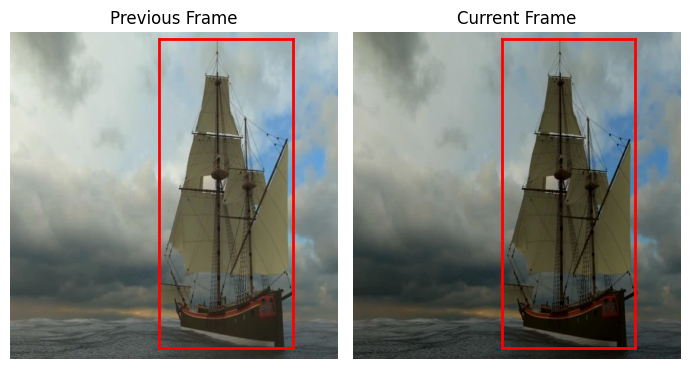

Visualized pair index: 1110656


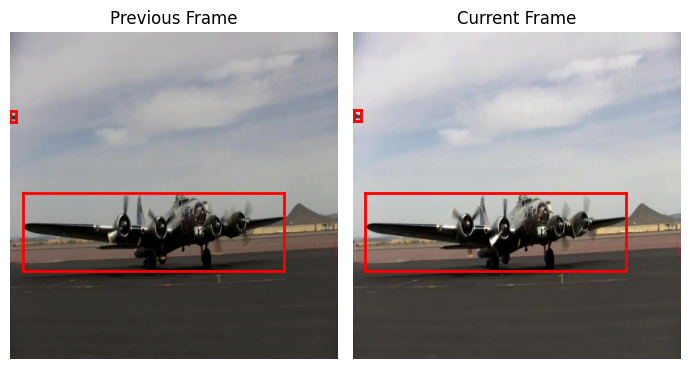

Visualized pair index: 600890


In [9]:
for _ in range(2):
    selected_idx = train_dataset.output_sampling(img_norm=IMG_NORM, imgsize=(IMG_SIZE, IMG_SIZE))
    print(f"Visualized pair index: {selected_idx}")

## DataLoader

In [10]:
def multi_object_collate_fn(batch):
    """ a custom collate function for multi-object detection dataset
    Pascal VOC format (x_min, y_min, x_max, y_max)
    """
    images = torch.stack([item[0] for item in batch])
    labels = [item[1]['boxes'] for item in batch]

    return images, labels

In [11]:
from transformers.image_transforms import corners_to_center_format


def _corners_to_center_format(bboxes):
    try:
        return corners_to_center_format(bboxes)
    except:
        return bboxes


def multi_object_collate_fn_yolo(batch):
    """ a custom collate function for multi-object detection dataset
    YOLO format (x_center, y_center, width, height)
    """
    bboxes = [_corners_to_center_format(item[1]['boxes']) for item in batch]
    labels = [item[1]['labels'] for item in batch]

    return torch.stack([item[0] for item in batch]), [torch.cat((label.unsqueeze(1), bbox), dim=1) for label, bbox in zip(labels, bboxes)]

In [12]:
# Set Batch Size
BATCH_SIZE = 32, 32, 1

In [13]:
MULTI_PROCESSING = True  # Set False if DataLoader is causing issues


import multiprocessing
from platform import system

cpu_cores = multiprocessing.cpu_count()
num_workers = 1
if MULTI_PROCESSING and system() != "Windows":  # Multiprocess data loading is not supported on Windows
    num_workers += ADDITIONAL_GPU
    print(f"INFO: Number of CPU cores - {num_workers}/{cpu_cores}")
else:
    print("INFO: Using DataLoader without multi-processing.")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE[0], shuffle=True, num_workers=num_workers, collate_fn=multi_object_collate_fn_yolo)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE[1], shuffle=False, num_workers=num_workers, collate_fn=multi_object_collate_fn_yolo)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE[2], shuffle=False, num_workers=num_workers, collate_fn=multi_object_collate_fn_yolo)

INFO: Number of CPU cores - 1/12


## Load Model

In [ ]:
def from_pretrained(self, model_id="yolo11m.pt"):
    model_dict = self.state_dict()
    pretrained_dict = torch.load(model_id)
    if 'model' in pretrained_dict:
        pretrained_dict = pretrained_dict['model'].float().state_dict()
    else:
        pretrained_dict = pretrained_dict['state_dict'] if 'state_dict' in pretrained_dict else pretrained_dict

    # Filtering detect layer (eg: model.24.xxx)
    detect_layer_name = f"model.{len(self.model)-1}"

    # Override model_dict with pretrained_dict except for detect layer
    filtered_dict = {k: v for k, v in pretrained_dict.items() if not k.startswith(detect_layer_name) and k in model_dict}
    model_dict.update(filtered_dict)
    self.load_state_dict(model_dict, strict=False)
    
    return self

In [27]:
from ultralytics.nn.tasks import DetectionModel
DetectionModel.from_pretrained = from_pretrained

model = DetectionModel("yolo11m.yaml", nc=len(train_dataset.obj_classes))
model = model.from_pretrained("./pretrained/yolo11m.pt")


if ADDITIONAL_GPU:
    model = nn.DataParallel(model, device_ids=list(range(DEVICE_NUM, DEVICE_NUM+ADDITIONAL_GPU+1)))
model.to(device)

Overriding model.yaml nc=80 with nc=30

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytic

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
   

## Train

In [15]:
# Set Epoch Count & Learning Rate
EPOCHS = 100
MODEL_BACKUP = 5
LEARNING_RATE = 1e-3, 1e-6  # Initial LR, minimum LR
WEIGHT_DECAY = 0.0005  # Standard weight decay for YOLO models
MOMENTUM = 0.937  # Common momentum value for YOLO

# Loss function weights
BBOX_LOSS_WEIGHT = 0.05  # For bounding box regression
CLS_LOSS_WEIGHT = 0.5   # For classification
OBJ_LOSS_WEIGHT = 1.0   # For objectness
CIoU_WEIGHT = 0.7       # For CIoU loss component

# Use YOLO's built-in optimization strategy instead of manual optimization
optimizer = optim.SGD(
    model.parameters(),
    lr=LEARNING_RATE[0],
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY,
    nesterov=True
)

# One-cycle learning rate scheduler
train_length, valid_length = map(len, (train_loader, valid_loader))
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE[0],
    total_steps=EPOCHS * len(train_loader),
    pct_start=0.1,  # Warm-up period
    div_factor=25,  # Initial LR = max_lr/div_factor
    final_div_factor=10000,  # Final LR = max_lr/(div_factor*final_div_factor)
)

In [16]:
model.train()

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3k2(
      (cv1): Conv(
        (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
   

In [17]:
test_batch = next(iter(train_loader))
test_batch

(tensor([[[[-1.4500, -1.4500, -1.4500,  ..., -1.9124, -1.9124, -1.8953],
           [-1.4500, -1.4500, -1.4500,  ..., -1.9124, -1.9124, -1.8953],
           [-1.4500, -1.4500, -1.4500,  ..., -1.9124, -1.9124, -1.8953],
           ...,
           [-0.8335, -0.8335, -0.8335,  ..., -2.0665, -2.0665, -2.0665],
           [-0.8164, -0.8164, -0.8164,  ..., -2.0665, -2.0665, -2.0665],
           [-0.8164, -0.8164, -0.8164,  ..., -2.0665, -2.0665, -2.0665]],
 
          [[-1.7556, -1.7556, -1.7556,  ..., -1.7731, -1.7731, -1.7731],
           [-1.7556, -1.7556, -1.7556,  ..., -1.7731, -1.7731, -1.7731],
           [-1.7556, -1.7556, -1.7556,  ..., -1.7731, -1.7731, -1.7731],
           ...,
           [-1.3880, -1.3880, -1.3880,  ..., -1.9832, -1.9832, -1.9832],
           [-1.3880, -1.3880, -1.3880,  ..., -1.9832, -1.9832, -1.9832],
           [-1.3880, -1.3880, -1.3880,  ..., -1.9832, -1.9832, -1.9832]],
 
          [[-1.6650, -1.6650, -1.6650,  ..., -1.5430, -1.5430, -1.5256],
           [-

In [18]:
test_batch[0].shape

torch.Size([32, 3, 640, 640])

In [19]:
test_batch = test_batch[0].to(device), [t.to(device) for t in test_batch[1]]
test_batch

(tensor([[[[-1.4500, -1.4500, -1.4500,  ..., -1.9124, -1.9124, -1.8953],
           [-1.4500, -1.4500, -1.4500,  ..., -1.9124, -1.9124, -1.8953],
           [-1.4500, -1.4500, -1.4500,  ..., -1.9124, -1.9124, -1.8953],
           ...,
           [-0.8335, -0.8335, -0.8335,  ..., -2.0665, -2.0665, -2.0665],
           [-0.8164, -0.8164, -0.8164,  ..., -2.0665, -2.0665, -2.0665],
           [-0.8164, -0.8164, -0.8164,  ..., -2.0665, -2.0665, -2.0665]],
 
          [[-1.7556, -1.7556, -1.7556,  ..., -1.7731, -1.7731, -1.7731],
           [-1.7556, -1.7556, -1.7556,  ..., -1.7731, -1.7731, -1.7731],
           [-1.7556, -1.7556, -1.7556,  ..., -1.7731, -1.7731, -1.7731],
           ...,
           [-1.3880, -1.3880, -1.3880,  ..., -1.9832, -1.9832, -1.9832],
           [-1.3880, -1.3880, -1.3880,  ..., -1.9832, -1.9832, -1.9832],
           [-1.3880, -1.3880, -1.3880,  ..., -1.9832, -1.9832, -1.9832]],
 
          [[-1.6650, -1.6650, -1.6650,  ..., -1.5430, -1.5430, -1.5256],
           [-

In [20]:
model(*test_batch)

 time (ms)     GFLOPs     params  module


AttributeError: 'Conv' object has no attribute 'np'

In [ ]:
epochs = tqdm(range(EPOCHS), desc="Running Epochs")
with (tqdm(total=train_length, desc="Training") as train_progress,
        tqdm(total=valid_length, desc="Validation") as valid_progress):  # Set up Progress Bars
    for epoch in epochs:
        train_progress.reset(total=train_length)
        valid_progress.reset(total=valid_length)

        #########################################################################################
        # Training
        #########################################################################################
        model.train()
        for i, (curr_frame, curr_gt) in enumerate(train_loader):
            optimizer.zero_grad()

            # Move inputs & targets to device
            curr_frame = curr_frame.to(device)
            curr_gt = [{k: v.to(device) for k, v in gt.items()} for gt in curr_gt]

            # Forward pass
            outputs = model(curr_frame)  # Returns pred_cls, pred_bbox, objectness
            pred = [{
                'boxes': outputs[1][idx],
                'scores': outputs[2][idx],
                'labels': outputs[0][idx]
            } for idx in range(len(outputs[0]))]

            # Calculate mAP
            calculate_map.update(outputs, curr_gt)
            batch_map = calculate_map.compute()

            # Combine losses with appropriate weights
            loss = (BBOX_LOSS_WEIGHT * ciou_loss +
                    CLS_LOSS_WEIGHT * cls_loss +
                    OBJ_LOSS_WEIGHT * obj_loss)

            loss.backward()
            optimizer.step()
            scheduler.step()

        #########################################################################################
        # Validation
        #########################################################################################

In [ ]:
# Finalize logging
exp.end()